In [6]:
import pandas as pd

data_path = 'CM_logD_regression.xlsx'

elements = ["Mn", "Co", "Ni", "Cu"]


df = pd.read_excel(data_path, sheet_name="combined_new")

df.head()



df.head()

# Remove rows with NaN values
df = df.dropna()

# Reset index after dropping NaN values
df = df.reset_index(drop=True)
df
# # scale each column by doing df[col] = df[col] / abs(df[col]).max()

sf_dict = {}
for col in df.columns:
    scaled_column_name = f"{col}_scaled"
    if df[col].dtype in ['float64', 'int64']:
        if col in ["pH", "[D2EHPA] ", "log D (obs)_Mn", "log D (obs)_Co", "log D (obs)_Ni", "log D (obs)_Cu"]:
            max_value = 1
            df[scaled_column_name] = df[col] / max_value
        else:
            if col in ["[Mn] (mol/L)", "[Co] (mol/L)", "[Ni] (mol/L)", "[Cu] (mol/L)"]:
                df[scaled_column_name] =  (df[col] - df[col].mean() )  / (df[col].max() - df[col].min() )    
            else:
                max_value = abs(df[col]).max()
                df[scaled_column_name] = df[col] / max_value

        sf_dict[col] = max_value
        print(f"Scaled {col} by {max_value}")



Scaled pH by 1
Scaled A/O by 2.61
Scaled [D2EHPA]  by 1
Scaled extraction_Mn by 99.97
Scaled extraction_Co by 70.91
Scaled extraction_Ni by 43.58
Scaled extraction_Cu by 96.59
Scaled Dobs_Mn by 4998.499999999811
Scaled Dobs_Co by 3.0813008130081303
Scaled Dobs_Ni by 1.2164683177870699
Scaled Dobs_Cu by 41.60344827586202
Scaled log D (obs)_Mn by 1
Scaled log D (obs)_Co by 1
Scaled log D (obs)_Ni by 1
Scaled log D (obs)_Cu by 1
Scaled [Mn] (mol/L) by 1
Scaled [Co] (mol/L) by 1
Scaled [Ni] (mol/L) by 1
Scaled [Cu] (mol/L) by 1


In [7]:
df.columns

Index(['pH', 'A/O', '[D2EHPA] ', 'extraction_Mn', 'extraction_Co',
       'extraction_Ni', 'extraction_Cu', 'Dobs_Mn', 'Dobs_Co', 'Dobs_Ni',
       'Dobs_Cu', 'log D (obs)_Mn', 'log D (obs)_Co', 'log D (obs)_Ni',
       'log D (obs)_Cu', '[Mn] (mol/L)', '[Co] (mol/L)', '[Ni] (mol/L)',
       '[Cu] (mol/L)', 'pH_scaled', 'A/O_scaled', '[D2EHPA] _scaled',
       'extraction_Mn_scaled', 'extraction_Co_scaled', 'extraction_Ni_scaled',
       'extraction_Cu_scaled', 'Dobs_Mn_scaled', 'Dobs_Co_scaled',
       'Dobs_Ni_scaled', 'Dobs_Cu_scaled', 'log D (obs)_Mn_scaled',
       'log D (obs)_Co_scaled', 'log D (obs)_Ni_scaled',
       'log D (obs)_Cu_scaled', '[Mn] (mol/L)_scaled', '[Co] (mol/L)_scaled',
       '[Ni] (mol/L)_scaled', '[Cu] (mol/L)_scaled'],
      dtype='object')

In [8]:
n_data = df.shape[0]

from idaes.core.util import model_statistics as mstat
import pyomo.environ as pyo
import numpy as np

m = pyo.ConcreteModel()

m.I = pyo.RangeSet(0, n_data-1)
m.elements = pyo.Set(initialize = elements)

# Input data vars
m.pH = pyo.Var(m.I, domain=pyo.Reals, initialize=0.0)
m.C_ex = pyo.Var(m.I, domain=pyo.Reals, initialize=0.0)
m.Cfeed = pyo.Var(m.I, m.elements, domain=pyo.Reals, initialize=0.0)


# Output variable
m.logD = pyo.Var(m.I, m.elements, domain=pyo.Reals, initialize=0.0)


# Parameters
ablist = [1, 2, 3, 4, 5, 6]

ai_list = [3, 4, 5, 6, 7]
bi_list = [1, 2]

m.a_set = pyo.Set(initialize = ablist)
m.b_set = pyo.Set(initialize = ablist)

m.ai_set = pyo.Set(initialize = ai_list)
m.bi_set = pyo.Set(initialize = bi_list)



m.a12 = pyo.Var(m.a_set, m.elements, domain=pyo.Reals, initialize=0.5)
m.b12 = pyo.Var(m.b_set, m.elements, domain=pyo.Reals, initialize=0.5)

m.ai = pyo.Var(m.ai_set, domain=pyo.Reals, initialize=0.5)

m.alpha = pyo.Var(m.I, m.elements, domain=pyo.Reals, initialize=0.5)
m.beta = pyo.Var(m.I, m.elements, domain=pyo.Reals, initialize=0.5)

name_mapper_general = {
    'pH_scaled': m.pH,
    '[D2EHPA] _scaled': m.C_ex}


def map_generator(element):
    return {
    f'[{element}] (mol/L)_scaled': m.Cfeed,
    f'log D (obs)_{element}_scaled': m.logD}



name_mapper_elements = {}

for element in m.elements:
    name_mapper_elements[element] = map_generator(element)


# # Initialize input variables
for col in name_mapper_general.keys():
    for i in df.index:
        name_mapper_general[col][i].fix(df[col][i])


for element in m.elements:
    for i in df.index:
        for col in name_mapper_elements[element].keys():
            name_mapper_elements[element][col][i, element].fix(df[col][i])
        
# # Model variales

m.logD_scaled_pred =  pyo.Var(m.I, m.elements, initialize = 0.1, domain=pyo.Reals)
m.Cext_net_pred = pyo.Var(m.I, domain=pyo.Reals, initialize=0.1, bounds = (1e-6, 2))
m.logCext_net_pred = pyo.Var(m.I, domain=pyo.Reals, initialize=0.1, bounds = (np.log10(1e-6), np.log10(2)))



# Constraints

@m.Constraint(m.I)
def logCext_net_pred_constraint(m, i):
    return 10**(m.logCext_net_pred[i]) == m.Cext_net_pred[i]


m.resid = pyo.Var(m.I, m.elements)

@m.Constraint(m.I, m.elements)
def alpha_const(m, i, e):
    return m.alpha[i, e] == m.a12[1, e]  + m.a12[2, e]*m.C_ex[i] + m.a12[3, e]*m.Cfeed[i, "Mn"] + m.a12[4, e]*m.Cfeed[i, "Co"] + m.a12[5, e]*m.Cfeed[i, "Ni"] + m.a12[6, e]*m.Cfeed[i, "Cu"] 

@m.Constraint(m.I, m.elements)
def b_const(m, i, e):
    return m.beta[i, e] == m.b12[1, e] + m.b12[2, e]*m.logCext_net_pred[i]

@m.Constraint(m.I)
def Cext_net_pred_constraint(m, i):
    return m.Cext_net_pred[i] == m.C_ex[i] - m.ai[3]*m.Cfeed[i, "Mn"] - m.ai[4]*m.Cfeed[i, "Co"]  -m.ai[5]*m.Cfeed[i, "Cu"] - m.ai[6]*m.Cfeed[i, "Ni"] + m.ai[7]

@m.Constraint(m.I, m.elements)
def logD_scaled_pred_constraint(m, i, e):
    return m.logD_scaled_pred[i, e] == m.alpha[i, e]*m.pH[i] + m.beta[i, e]
@m.Objective(sense = pyo.minimize)
def objective_function(m):
    return sum((m.logD_scaled_pred[i, e] - m.logD[i, e])**2 for i in m.I for e in m.elements)

# contributing terms
@m.Expression(m.elements)
def sse_element(m, e):
    return sum((m.logD_scaled_pred[i, e] - m.logD[i, e])**2 for i in m.I)


@m.Expression(m.I, m.elements)
def D(m, i, e):
    return 10**m.logD_scaled_pred[i, e]

@m.Expression(m.I, m.elements)
def extraction_perc(m, i, e):
    A_O = df["A/O"][i]

    return m.D[i,e] / (m.D[i,e] + A_O) *100


mstat.degrees_of_freedom(m)
solver = pyo.SolverFactory('ipopt_v2')
solver.options['halt_on_ampl_error'] = 'no'
solver.options['max_iter'] = 200

results = solver.solve(m, tee=True, symbolic_solver_labels=True)

Ipopt 3.13.2: halt_on_ampl_error=no
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientif

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2415438403.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


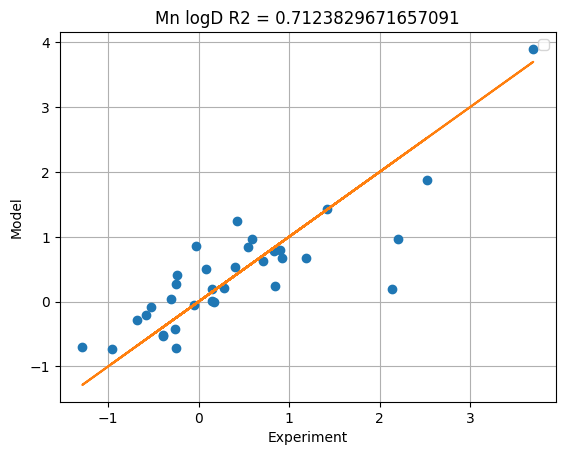

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2415438403.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


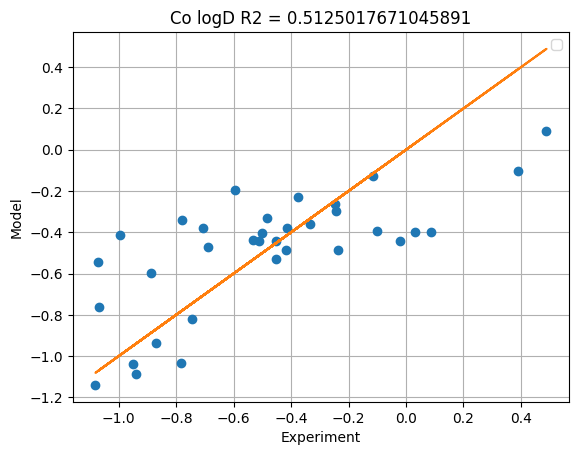

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2415438403.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


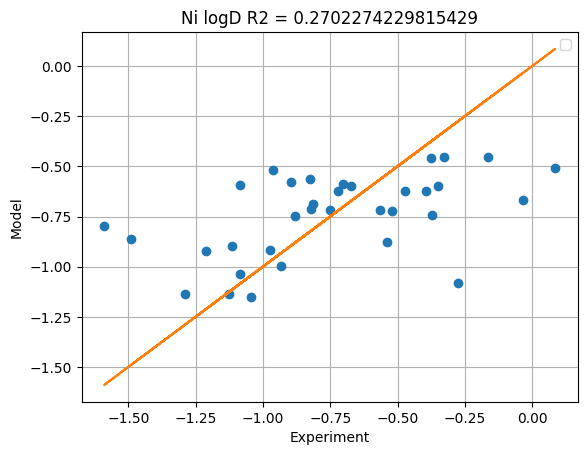

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2415438403.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


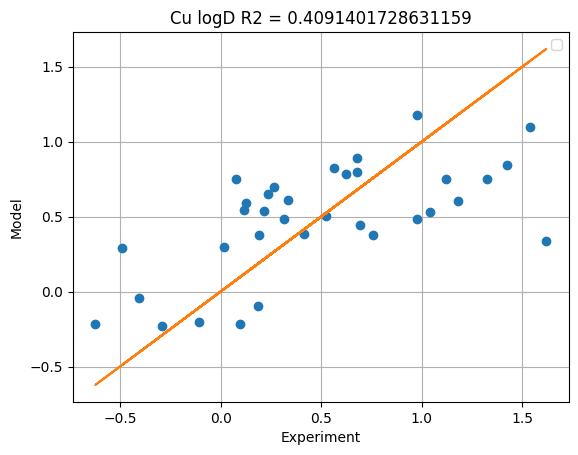

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

for element in m.elements:
    # for i in m.I:
        # if 0.0 <= m.logD_scaled_pred[i,element]() <= 0.2:
    plt.plot(m.logD[:, element](), m.logD_scaled_pred[:,element](), 'o')#, label=f'{i}')
    plt.plot(m.logD[:, element](), m.logD[:, element]())
    plt.xlabel(f'Experiment')
    plt.ylabel('Model')
    plt.grid()
    plt.title(f'{element} logD R2 = {r2_score(m.logD[:, element](), m.logD_scaled_pred[:,element]())}')
    plt.legend()
    plt.show()

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2961781852.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


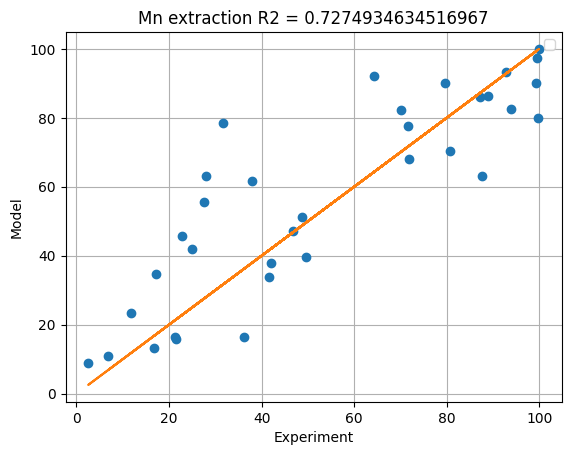

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2961781852.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


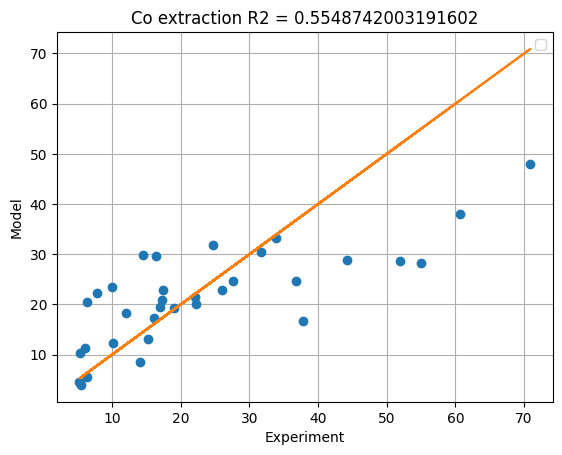

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2961781852.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


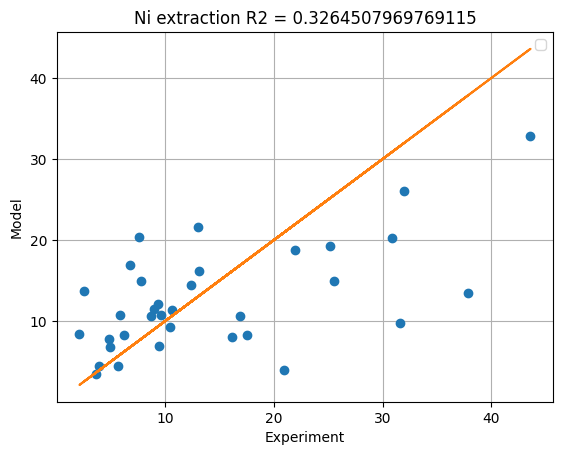

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_19428\2961781852.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


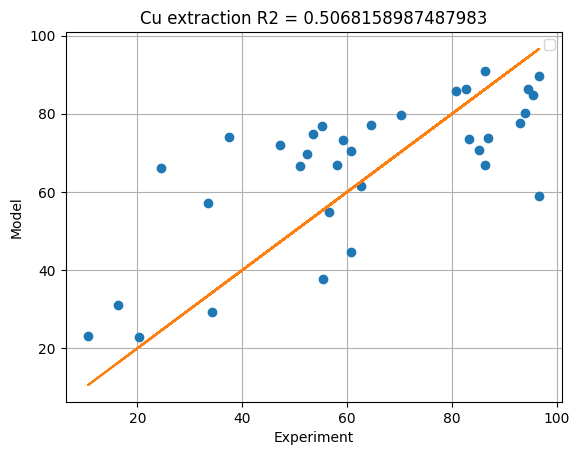

In [10]:
for element in m.elements:
    plt.plot(df[f"extraction_{element}"], m.extraction_perc[:, element](), 'o')
    plt.plot(df[f"extraction_{element}"], df[f"extraction_{element}"])
    plt.plot()
    plt.xlabel('Experiment')
    plt.ylabel('Model')
    plt.grid()
    plt.title(f'{element} extraction R2 = {r2_score(df[f"extraction_{element}"], m.extraction_perc[:, element]())}')
    plt.legend()
    plt.show()

In [11]:
from sklearn.metrics import r2_score

R_2_logD_values = {}
R_2_extract_values = {}
for element in m.elements:
    R_2_logD_values[element] = r2_score(m.logD[:, element](), m.logD_scaled_pred[:,element]())
    R_2_extract_values[element] = r2_score(df[f"extraction_{element}"], m.extraction_perc[:, element]())

print(R_2_logD_values)
print(R_2_extract_values)

{'Mn': 0.7123829671657091, 'Co': 0.5125017671045891, 'Ni': 0.2702274229815429, 'Cu': 0.4091401728631159}
{'Mn': 0.7274934634516967, 'Co': 0.5548742003191602, 'Ni': 0.3264507969769115, 'Cu': 0.5068158987487983}


In [12]:
df.to_excel("debug_data.xlsx")

PermissionError: [Errno 13] Permission denied: 'debug_data.xlsx'

In [14]:
element = "Ni"

print(f"Element = {element}")
print(f"a1-2 = {m.a12[:, element]()}")
print(f"b1-2 = {m.b12[:, element]()}")
print(f"ai(3-6): {m.ai[:]()}")

Element = Ni
a1-2 = [0.3058143674103955, -0.30049195777635346, 0.36667962514920527, -0.17525182951839266, -0.13746490626808963, 0.014593487336289089]
b1-2 = [-2.1213361686994, 4.999056509280432, 0.5, 0.5, 0.5, 0.5]
ai(3-6): [1.0029619944915857, -0.44784491116222996, 0.21674397901853903, -0.22615907192939913, 1.1364883186329469]


In [ ]:
for element in m.elements:
    plt.plot(m.Cext_net_pred[:](), m.resid[:,element](), 'o')
    plt.xlabel(f'C_ex_net')
    plt.ylabel('resid')
    plt.grid()
    plt.title(element)
    plt.show()

# Residual plots (for a = a1 + resid)

In [ ]:
@m.Expression(m.I)
def trm(m, i):
    return - m.ai[3]*m.Cfeed[i, "Mn"] - m.ai[4]*m.Cfeed[i, "Co"]  -m.ai[5]*m.Cfeed[i, "Cu"] - m.ai[6]*m.Cfeed[i, "Ni"]

plt.plot(m.trm[:]())
plt.plot(m.C_ex[:]())

# Outlier Detection

In [ ]:
!pip install scikit-learn

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ---------------------------------------- 10.7/10.7 MB 53.2 MB/s eta 0:00:00


In [ ]:
data = df[[ 'pH_scaled','[D2EHPA] _scaled', '[Mn] (mol/L)_scaled', '[Co] (mol/L)_scaled',
       '[Ni] (mol/L)_scaled', '[Cu] (mol/L)_scaled', 'log D (obs)_Mn_scaled',
       'log D (obs)_Co_scaled'] ]

X = X_data = data.to_numpy()

C:\Users\ad00105\AppData\Local\Temp\1\ipykernel_18664\2021683680.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


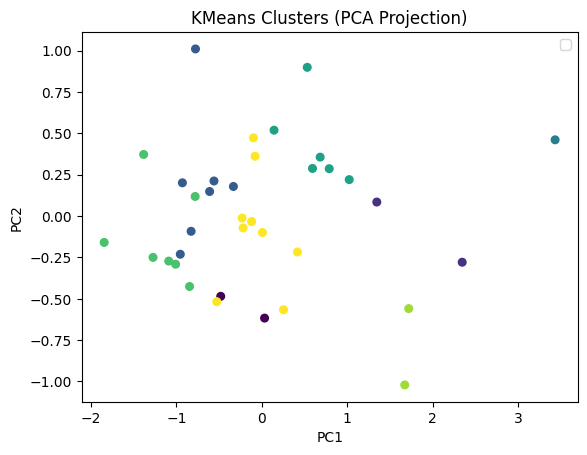

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_clusters = 5
# Fit KMeans
kmeans = KMeans(n_clusters=8)
labels = kmeans.fit_predict(X)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=30, cmap='viridis')
# plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (PCA Projection)")
plt.legend()
plt.show()



In [ ]:
kmeans.transform(X)

array([[1.4271483 , 2.12938931, 1.39255173, 4.41522952, 0.97834674,
        3.19185416, 1.51250777, 1.5207616 ],
       [1.95913743, 0.92243448, 1.19006377, 3.19944388, 1.4539122 ,
        1.66508674, 0.98291122, 0.4295292 ],
       [0.80288019, 2.16110401, 1.22962496, 4.60957678, 0.50505869,
        2.94411499, 1.14527358, 1.83738548],
       [1.7142265 , 1.1790527 , 0.90640847, 3.33729445, 1.33523902,
        1.62437054, 0.71087256, 1.01612929],
       [2.02113518, 0.53183429, 1.26409223, 3.04912118, 1.51141393,
        1.6787854 , 0.90075757, 0.79881779],
       [0.77743687, 2.94285988, 1.67323929, 5.44807405, 1.2841594 ,
        3.80524283, 1.95442468, 2.55671615],
       [1.08586746, 1.74844911, 1.03539061, 4.29297617, 0.87656347,
        2.47101554, 0.935956  , 1.58049857],
       [1.61164704, 1.04821513, 1.05035526, 3.55899802, 1.05484758,
        2.16946729, 0.72827415, 0.79240459],
       [0.57895755, 2.14088273, 1.07776805, 4.67602663, 0.81350574,
        3.00335521, 1.131864

In [ ]:
labels

array([2, 1, 5, 6, 1, 0, 5, 1, 0, 6, 7, 5, 0, 5, 1, 5, 1, 6, 4, 6, 4, 6,
       0, 3, 2, 6, 6, 2, 6, 0, 6, 7, 6, 1, 6, 6], dtype=int32)

In [ ]:

for i in range(n_clusters):
    print(i, np.where(labels == i))

0 (array([ 5,  8, 12, 15, 22, 27, 29]),)
1 (array([ 4, 14, 16, 18]),)
2 (array([ 9, 13, 17, 25]),)


In [ ]:
99.99/(100-99.99)

9998.999999994885